In [1]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [2]:
import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation
import dipy.data as dpd

In [3]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
import bundlenet as bn

In [5]:
import dask.bag as db

In [6]:
dpd.fetch_bundles_2_subjects()

Data size is approximately 234MB
Dataset is already in place. If you want to fetch it again please first remove the folder /home/ubuntu/.dipy/exp_bundles_and_maps 


({'bundles_2_subjects.tar.gz': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/38477/bundles_2_subjects.tar.gz',
   '97756fbef11ce2df31f1bedf1fc7aac7')},
 '/home/ubuntu/.dipy/exp_bundles_and_maps')

In [7]:
ls /home/ubuntu/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/

bundles_af.left.trk   bundles_cg.left.trk     bundles_mdlf.right.trk
bundles_af.right.trk  bundles_cg.right.trk    bundles_slf1.left.trk
bundles_cc_1.trk      bundles_cst.left.trk    bundles_slf1.right.trk
bundles_cc_2.trk      bundles_cst.right.trk   bundles_slf2.left.trk
bundles_cc_3.trk      bundles_ifof.left.trk   bundles_slf2.right.trk
bundles_cc_4.trk      bundles_ifof.right.trk  bundles_slf_3.left.trk
bundles_cc_5.trk      bundles_ilf.left.trk    bundles_slf_3.right.trk
bundles_cc_6.trk      bundles_ilf.right.trk   bundles_uf.left.trk
bundles_cc_7.trk      bundles_mdlf.left.trk   bundles_uf.right.trk


In [8]:
bundle_files = glob('/home/ubuntu/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/*.trk')

In [9]:
t1_img = nib.load('/home/ubuntu/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/t1_warped.nii.gz')
vol_shape=t1_img.shape
vol_shape

(256, 256, 150)

In [10]:
n_streamlines = []
bundle_names = []
for fname in bundle_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    n_streamlines.append(len(streamlines))

In [11]:
bundle_names

['ifof.left',
 'slf_3.right',
 'slf1.right',
 'af.left',
 'cc_3',
 'slf1.left',
 'ilf.left',
 'cc_2',
 'mdlf.left',
 'slf_3.left',
 'cc_1',
 'uf.right',
 'ilf.right',
 'cc_6',
 'cc_5',
 'cc_7',
 'ifof.right',
 'cg.right',
 'slf2.left',
 'cg.left',
 'uf.left',
 'cst.left',
 'cst.right',
 'slf2.right',
 'af.right',
 'mdlf.right',
 'cc_4']

In [12]:
np.min(n_streamlines), len(n_streamlines)

(161, 27)

In [13]:
take_n_bundles = len(n_streamlines)
take_n_sl = np.min(n_streamlines)

test_perc=0.2
val_perc=0.2
size_slimage = 100

In [14]:
import imp  
imp.reload(bn)

if op.exists('./subject1_bundles.npz'):
    # Read it from file:
    loaded_from_file = np.load('./subject1_bundles.npz')
    labels_test = loaded_from_file['labels_test']
    labels_val = loaded_from_file['labels_val']
    labels_train = loaded_from_file['labels_train']
    data_test = loaded_from_file['data_test']
    data_val = loaded_from_file['data_val']
    data_train = loaded_from_file['data_train']
else:
    streamlines_loaded = db.from_sequence(bundle_files).map(bn.read_sl).compute()
    streamlines_processed = db.from_sequence(streamlines_loaded).map(bn.process_sl,take_n_sl,vol_shape,size_slimage).compute() 
    data_train, data_test, data_val, labels_train, labels_test, labels_val = bn.partition_testtrain(test_perc, val_perc, streamlines_processed)
    np.savez('./subject1_bundles', data_train=data_train, labels_train=labels_train, data_val=data_val, labels_val=labels_val, data_test=data_test, labels_test=labels_test)

In [15]:
img_rows = size_slimage
img_cols = size_slimage
batch_size = 4
epochs = 24
num_classes = take_n_bundles
input_shape = (img_rows, img_cols,1)

In [16]:
labels_train = keras.utils.to_categorical(labels_train, num_classes)
labels_test  = keras.utils.to_categorical(labels_test, num_classes)
labels_val  = keras.utils.to_categorical(labels_val, num_classes)

In [17]:
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

In [18]:
labels_train.shape


(2607, 27)

In [19]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=input_shape,padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(Dropout(0.25))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))

In [20]:
from IPython.display import SVG
from keras.utils import plot_model
#from vis_utils import plot_model
plot_model(model, to_file='model.png')

In [21]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [22]:
filepath="checkpoints/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [23]:
#create checkpoints dir
training = model.fit(data_train, labels_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_val, labels_val),
                     callbacks=callbacks_list)

Train on 2607 samples, validate on 870 samples
Epoch 1/24
2607/2607 [==============================] - 52s 20ms/step - loss: 0.5903 - acc: 0.8178 - val_loss: 0.1939 - val_acc: 0.9379

Epoch 00001: val_acc improved from -inf to 0.93793, saving model to checkpoints/weights.best.hdf5
Epoch 2/24
2607/2607 [==============================] - 47s 18ms/step - loss: 0.2153 - acc: 0.9202 - val_loss: 0.1678 - val_acc: 0.9368

Epoch 00002: val_acc did not improve from 0.93793
Epoch 3/24
2607/2607 [==============================] - 47s 18ms/step - loss: 0.1747 - acc: 0.9310 - val_loss: 0.1716 - val_acc: 0.9195

Epoch 00003: val_acc did not improve from 0.93793
Epoch 4/24
2607/2607 [==============================] - 47s 18ms/step - loss: 0.1537 - acc: 0.9386 - val_loss: 0.1556 - val_acc: 0.9391

Epoch 00004: val_acc improved from 0.93793 to 0.93908, saving model to checkpoints/weights.best.hdf5
Epoch 5/24
2607/2607 [==============================] - 47s 18ms/step - loss: 0.1183 - acc: 0.9528 - val_l

In [24]:
data_test.shape

(870, 100, 100, 1)

In [25]:
model.load_weights("checkpoints/weights.best.hdf5")

In [26]:
score = model.evaluate(data_test, labels_test, verbose=0)

In [27]:
print(score)

[0.24162423042902978, 0.9413793103448276]


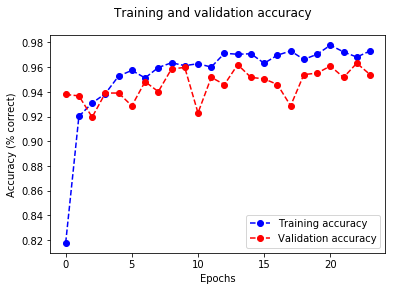

In [28]:
fig = bn.plot_accuracy(training)

In [29]:
p = model.predict(data_test, batch_size=5)

In [30]:
p_idx = np.argmax(p, axis=-1)
labels_test_idx = np.argmax(labels_test, axis=-1)

In [31]:
imp.reload(bn)
bn.print_accuarcystats(p_idx,labels_test_idx)

Percent correct is 0.9413793103448276 
Kappa is: 0.9391241116263754
Jaccard is: 0.9413793103448276


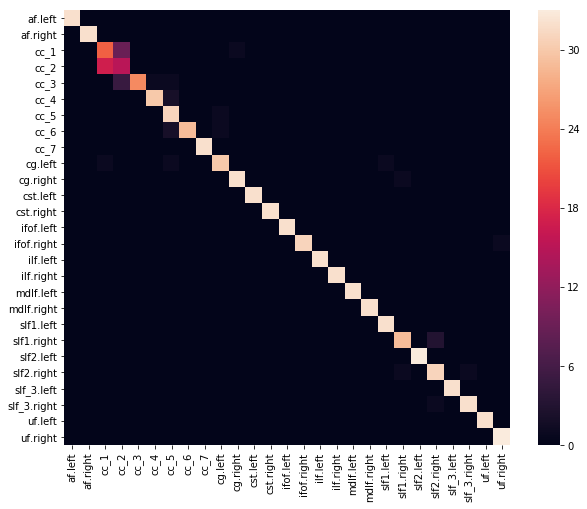

In [32]:
bn.plotconfusionmat(bundle_names, p_idx, labels_test_idx)

In [33]:
from sklearn.metrics import cohen_kappa_score, jaccard_similarity_score,confusion_matrix

p_idx = np.argmax(p, axis=-1)
labels_actual_idx = np.argmax(labels_test, axis=-1)
labels = np.array(range(min(p_idx),max(p_idx)+1))
confusion_mat = confusion_matrix(labels_actual_idx,p_idx, labels)

Cross-predict on *another subject*

In [34]:
sub2_bundle_files = glob('/home/ubuntu/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_2/bundles/*.trk')

In [35]:
sub2_t1_img = nib.load('/home/ubuntu/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_2/t1_warped.nii.gz')

In [36]:
n_streamlines = 0
for fname in sub2_bundle_files:
    streamlines = bn.read_sl(fname)
    n_streamlines += len(streamlines)

In [37]:
n_streamlines

57060

In [38]:
import imp  
imp.reload(bn)
vol_shape_subj2 = sub2_t1_img.shape
streamlines_loaded_subj2 = db.from_sequence(sub2_bundle_files).map(bn.read_sl).compute()
streamlines_processed_subj2 = db.from_sequence(streamlines_loaded_subj2).map(bn.process_sl,-1,vol_shape_subj2,size_slimage).compute() 

/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enab

KeyboardInterrupt: 

In [ ]:
len(streamlines_loaded_subj2[10])

In [ ]:
vol_shape_subj2

In [ ]:
all_streamlines, all_labels = bn.getdata(streamlines_processed_subj2)

In [ ]:
p_subj2 = model.predict(all_streamlines, batch_size=5)

In [ ]:
p_idx = np.argmax(p_subj2, axis=-1)

In [ ]:
bn.print_accuarcystats(p_idx,all_labels)

In [ ]:
bn.plotconfusionmat(bundle_names, p_idx, all_labels)

In [ ]:
p_error = p_subj2[~(p_idx == all_labels)]
p_correct = p_subj2[p_idx == all_labels]

In [ ]:
fig, ax = plt.subplots(1)
ax.hist(np.max(p_correct, -1), histtype='step', linewidth=2, normed=True, bins=10, label="Correct")
ax.hist(np.max(p_error, -1), histtype='step', linewidth=2, normed=True, bins=10, label="Incorrect")
ax.set_xlabel("Probability of chosen category")
ax.set_ylabel("Normalized frequency")
plt.legend(loc="upper left")

In [ ]:
sl = bn.read_sl("/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/sub-01_sess-01_dwiDTI_det_streamlines.trk")

In [ ]:
dwi_img = nib.load('/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/sub-01_sess-01_dwi_b0.nii.gz')
vol_shape_dwi=dwi_img.shape
vol_shape_dwi

In [ ]:
import imp  
imp.reload(bn)

stan_loaded = db.from_sequence(["/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/clean_bundles/SLF_L.trk"]).map(bn.read_sl).compute()
stan_streamlines_processed = db.from_sequence(stan_loaded).map(bn.process_sl,size_slimage,vol_shape_dwi,size_slimage).compute() 
tmp = stan_streamlines_processed[0]
plt.matshow(np.squeeze(np.sum(tmp,axis=0))) 
tmp1 = tmp[:,:,0,:]
plt.matshow(np.squeeze(tmp[10,:,:,:]))

In [ ]:
atlas_loaded = db.from_sequence([bundle_files[9]]).map(bn.read_sl).compute()
atlas_streamlines_processed = db.from_sequence(atlas_loaded).map(bn.process_sl,100,vol_shape,size_slimage).compute() 
tmp = atlas_streamlines_processed[0]
plt.matshow(np.squeeze(np.sum(tmp,axis=0)))
tmp1 = tmp[:,:,0,:]
plt.matshow(np.squeeze(tmp[1,:,:,:]))

In [ ]:
bundle_files_afq = glob('/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/clean_bundles/*.trk')

In [ ]:
streamlines_loaded_afq = db.from_sequence(bundle_files_afq).map(bn.read_sl).compute()

In [ ]:
num_sl = 1000
streamlines_processed_afq = db.from_sequence(streamlines_loaded_afq).map(bn.process_sl,num_sl,vol_shape_dwi,size_slimage).compute() 

In [ ]:
len(streamlines_loaded_afq[19])

In [ ]:
all_streamlines_afq, all_labels_afq = bn.getdata(streamlines_processed_afq)

In [ ]:
p_afq = model.predict(all_streamlines_afq, batch_size=5)

In [ ]:
p_idx_afq = np.argmax(p_afq, axis=-1)

In [ ]:
bundle_names_afq = []
for fname in bundle_files_afq:
    bundle_names_afq.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])

In [ ]:
import statistics as stat

prob = np.max(p_afq,axis=-1)

for i in range(len(bundle_names_afq)):
    print("AFQ bundle= " + str(bundle_names_afq[i]))
    tmp = p_idx_afq[(num_sl*i):(num_sl-1)+(num_sl*i)]
    m = stat.mode(tmp)
    print("Most likely bundle= " + str(bundle_names[m]))
    tmp2 = prob[(num_sl*i):(num_sl-1)+(num_sl*i)]
    p = np.mean(prob[(num_sl*i):(num_sl-1)+(num_sl*i)])
    p2 = np.mean(tmp2[tmp==m])
    print("Mean probability over all SLs= " + str(p))
    print("Mean probability over 'correct' SLs= " + str(p2))
    c = sum(tmp==m)
    print("Fraction of SLs with this most likely class= " + str(c/num_sl))
    print("        ")

In [ ]:
prob.shape

In [ ]:
bundle_files_afq2 = glob('/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/bundles/*.trk')
streamlines_loaded_afq2 = db.from_sequence(bundle_files_afq2).map(bn.read_sl).compute()
num_sl = 1000
streamlines_processed_afq2 = db.from_sequence(streamlines_loaded_afq2).map(bn.process_sl,num_sl,vol_shape_dwi,size_slimage).compute() 
all_streamlines_afq2, all_labels_afq2 = bn.getdata(streamlines_processed_afq2)
p_afq = model.predict(all_streamlines_afq2, batch_size=5)
p_idx_afq = np.argmax(p_afq, axis=-1)
bundle_names_afq2 = []
for fname in bundle_files_afq2:
    bundle_names_afq2.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])

In [ ]:
import statistics as stat

prob = np.max(p_afq,axis=-1)

for i in range(len(bundle_names_afq2)):
    print("AFQ bundle= " + str(bundle_names_afq2[i]))
    tmp = p_idx_afq[(num_sl*i):(num_sl-1)+(num_sl*i)]
    m = stat.mode(tmp)
    print("Most likely bundle= " + str(bundle_names[m]))
    tmp2 = prob[(num_sl*i):(num_sl-1)+(num_sl*i)]
    p = np.mean(prob[(num_sl*i):(num_sl-1)+(num_sl*i)])
    p2 = np.mean(tmp2[tmp==m])
    print("Mean probability over all SLs= " + str(p))
    print("Mean probability over 'correct' SLs= " + str(p2))
    c = sum(tmp==m)
    print("Fraction of SLs with this most likely class= " + str(c/num_sl))
    print("        ")